# **FlashPoint: Fire Rescue**

## **¿Qué debemos hacer?**

⦁ Una estrategia **aleatoria**

⦁ Una estrategia **desarrollada por nosotros** (sistema de prioridades + subastas)

⦁ Puede haber más de un agente por celda

⦁ La segunda estrategia debe mejorar significativamente respecto a la aleatoria (respaldada por datos comparativos)

⦁ Visualización en Unity con vista superior en 2D utilizando modelos 3D

⦁ Permitir desplazar la cámara por todo el escenario

## **Cada turno:**

### **1. Tomar acción**

Cada bombero recibe exactamente **4 Puntos de Acción (AP)** al inicio de su turno. No se acumulan entre turnos.

Se gastan los AP en: Moverse, Extinguir incendios, derribar paredes, cargar/evacuar víctimas, abrir/cerrar puertas, etc.

**Precios:**

⦁ Moverse a un espacio sin fuego → 1 AP

⦁ Moverse a un espacio con fuego → 2 AP

⦁ Moverse cargando a una víctima → 2 AP (independiente del terreno)

⦁ Recoger víctima (pickup) → 2 AP

⦁ Revelar falsa alarma → 0 AP (automático al entrar al espacio)

⦁ Abrir / Cerrar puerta adyacente → 1 AP

⦁ Extinguir fuego (remover completamente) → 2 AP

⦁ Extinguir humo → 1 AP

⦁ Demoler muro → 2 AP, agrega 1 punto de daño (una pared con 2 puntos de daño permite el paso)

**Restricciones importantes:**

⦁ No puedes cargar víctimas a través de espacios con fuego

⦁ No puedes terminar tu turno en un espacio con fuego (knocked down)

⦁ Cada agente solo puede cargar una víctima a la vez

⦁ Puedes moverte a través de paredes con 2+ puntos de daño

⦁ Las puertas deben estar abiertas para pasar (o puedes abrirlas por 1 AP)

### **2. Avanza el fuego**

Después de que un bombero termina sus acciones, se avanza el fuego:

1. Se selecciona una casilla **aleatoria dentro de los límites de la casa** (bounds: x[2-7], y[1-8])

2. Esa es la casilla objetivo donde se intentará colocar humo

**Reglas de propagación (según el contenido de la casilla objetivo):**

⦁ **Fuego + Fuego** = EXPLOSIÓN (extiende fuego en 4 direcciones)

⦁ **Humo + Humo adyacente** = Ambos se convierten en Fuego (se remueve uno de los humos)

⦁ **Humo + Fuego adyacente** = Humo se convierte en Fuego

⦁ **Víctima** = Víctima muere, espacio se convierte en Humo

⦁ **Falsa Alarma** = Se resuelve automáticamente, espacio se convierte en Humo

⦁ **Espacio vacío** = Se coloca Humo

⦁ **Bombero en casilla** = No ocurre nada (se ignora)

### **Efectos Secundarios**

⦁ **Flashover** (después de CADA cambio de fuego/humo):
  - Cualquier humo adyacente a fuego se convierte en fuego
  - Se repite iterativamente hasta que no quede humo adyacente a fuego (máximo 10 iteraciones)

⦁ **Knocked Down** (después del flashover):
  - Bomberos que terminan en espacios con fuego son derribados
  - Regresan a su posición inicial fuera de la casa
  - Se marcan como muertos (alive = False)
  - Si cargaban víctima, ésta se pierde
  - Se activa un bombero de respaldo si está disponible

⦁ **Explosiones** (cuando Fuego + Fuego):
  - Se irradian en las 4 direcciones cardinales desde el espacio objetivo
  - Colocan fuego en espacios adyacentes vacíos
  - Convierten humo a fuego en espacios con humo
  - Colocan marcadores de daño (+1) en paredes que bordean el espacio objetivo
  - Abren puertas cerradas que bordean el espacio objetivo
  - El espacio de explosión recibe +1 daño estructural
  - **IMPORTANTE**: No hay implementado Shockwave (propagación extendida)

### **3. Reponer marcas de POI**

⦁ Debe haber siempre **3 POI activos** en el tablero al final de cada turno

⦁ Se cuentan POI no revelados + víctimas reveladas en el tablero + falsas alarmas en el tablero

⦁ Si hay menos de 3, se generan nuevos aleatoriamente dentro de la casa

⦁ Si el espacio tiene fuego/humo, se remueve antes de colocar el POI

⦁ Si el espacio ya tiene POI, se recalcula la ubicación

⦁ **Pools limitados**: 10 víctimas totales, 5 falsas alarmas totales en toda la partida

## **Condiciones de Victoria/Derrota**

**Victoria:**

⦁ Rescatar 7 víctimas

**Derrota (cualquiera de estas):**

⦁ 4 víctimas muertas

⦁ 24 puntos de daño estructural acumulados

⦁ Todos los bomberos muertos (sin respaldos disponibles)

## **Configuración del Juego**

⦁ Grid: 10x10

⦁ Casa: 6x8 (coordenadas x[2-7], y[1-8])

⦁ Bomberos: 6 totales (4 activos iniciales + 2 de respaldo)

⦁ Fuegos iniciales: 10 (colocados aleatoriamente en la casa)

⦁ POIs iniciales: 3

⦁ Puertas interiores: 8 (todas cerradas al inicio)

⦁ Entradas exteriores: 4 (siempre abiertas)

## **Orden de Ejecución por Turno**

1. **Bombero recibe 4 AP**
2. **Sistema de subastas asigna objetivo** (si aplica)
3. **Bombero ejecuta acciones** según sistema de prioridades hasta agotar AP
4. **Avanza el fuego** (casilla aleatoria)
5. **Aplica flashover** (propagación en cadena)
6. **Verifica knocked down** (bomberos en fuego)
7. **Repone POIs** (si hay menos de 3)
8. **Verifica condiciones de fin** (victoria/derrota)
9. **Siguiente bombero...**

In [41]:
!pip install numpy scipy matplotlib seaborn scikit-learn mesa -q

In [42]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import heapq
from enum import Enum
import random
from collections import defaultdict

In [43]:
class SimpleScheduler:
    def __init__(self, model):
        self.model = model
        self.agents = []
        self.steps = 0

    def add(self, agent):
        self.agents.append(agent)

    def step(self):
        for agent in self.agents:
            agent.step()
        self.steps += 1

In [44]:
class CellState(Enum):
    EMPTY = 0
    FALSE_ALARM = 1
    SMOKE = 2
    FIRE = 3
    VICTIM = 4
    FIREFIGHTER = 5
    POI = 6
    EXTERIOR = 7

class ObjectiveType(Enum):
    VICTIM = "victim"
    FALSE_ALARM = "false_alarm"
    FIRE = "fire"

In [45]:
def get_neighbors_4dir(pos, width, height):
    x, y = pos
    neighbors = []
    for dx, dy in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
        nx, ny = x + dx, y + dy
        if 0 <= nx < width and 0 <= ny < height:
            neighbors.append((nx, ny))
    return neighbors

def manhattan_distance(pos1, pos2):
    return abs(pos1[0] - pos2[0]) + abs(pos1[1] - pos2[1])

def is_inside_house(pos, house_bounds):
    x, y = pos
    x_min, x_max, y_min, y_max = house_bounds
    return x_min <= x <= x_max and y_min <= y <= y_max

class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def push(self, priority, item):
        heapq.heappush(self.elements, (priority, item))

    def pop(self):
        return heapq.heappop(self.elements)[1]


In [46]:
class WallSystem:
    def __init__(self, width, height, house_bounds):
        self.width = width
        self.height = height
        self.house_bounds = house_bounds
        self.walls = {}
        self.doors = {}
        self.doors_opened = 0
        self.total_doors = 0

        self.wall_matrix = [
            ["1001", "1000", "1100", "1001", "1100", "1001", "1000", "1100"],
            ["0001", "0000", "0110", "0011", "0110", "0011", "0010", "0110"],
            ["0001", "0100", "1001", "1000", "1000", "1100", "1001", "1100"],
            ["0011", "0110", "0011", "0010", "0010", "0110", "0011", "0110"],
            ["1001", "1000", "1000", "1000", "1100", "1001", "1100", "1101"],
            ["0011", "0010", "0010", "0010", "0110", "0011", "0110", "0111"]
        ]

        self._initialize_walls()
        self._initialize_doors()

    def _initialize_walls(self):
        x_min, x_max, y_min, y_max = self.house_bounds
        for i in range(len(self.wall_matrix)):
            for j in range(len(self.wall_matrix[0])):
                x = x_min + i
                y = y_min + j
                pattern = self.wall_matrix[i][j]

                if pattern[0] == '1' and i > 0:
                    neighbor = (x - 1, y)
                    key = tuple(sorted([(x, y), neighbor]))
                    self.walls[key] = 0
                if pattern[1] == '1' and j < len(self.wall_matrix[0]) - 1:
                    neighbor = (x, y + 1)
                    key = tuple(sorted([(x, y), neighbor]))
                    self.walls[key] = 0
                if pattern[2] == '1' and i < len(self.wall_matrix) - 1:
                    neighbor = (x + 1, y)
                    key = tuple(sorted([(x, y), neighbor]))
                    self.walls[key] = 0
                if pattern[3] == '1' and j > 0:
                    neighbor = (x, y - 1)
                    key = tuple(sorted([(x, y), neighbor]))
                    self.walls[key] = 0

    def _initialize_doors(self):
        x_min, x_max, y_min, y_max = self.house_bounds
        interior_doors = [
            (1, 3, 1, 4), (1, 6, 1, 7), (2, 5, 2, 6), (2, 8, 3, 8),
            (3, 2, 3, 3), (4, 4, 5, 4), (4, 6, 4, 7), (6, 5, 6, 6),
        ]

        for r1, c1, r2, c2 in interior_doors:
            x1 = x_min + (r1 - 1)
            y1 = y_min + (c1 - 1)
            x2 = x_min + (r2 - 1)
            y2 = y_min + (c2 - 1)
            key = tuple(sorted([(x1, y1), (x2, y2)]))
            self.doors[key] = {"open": False}
            self.total_doors += 1
            if key in self.walls:
                del self.walls[key]

        exterior_entries = [
            ((x_min, y_min + 3), (x_min - 1, y_min + 3)),
            ((x_min, y_min + 4), (x_min - 1, y_min + 4)),
            ((x_max, y_min + 3), (x_max + 1, y_min + 3)),
            ((x_max, y_min + 4), (x_max + 1, y_min + 4)),
        ]

        for pos1, pos2 in exterior_entries:
            key = tuple(sorted([pos1, pos2]))
            if key in self.walls:
                del self.walls[key]

    def can_move(self, from_pos, to_pos):
        key = tuple(sorted([from_pos, to_pos]))
        if key in self.doors:
            return self.doors[key]["open"]
        if key in self.walls:
            return self.walls[key] >= 2
        return True

    def open_door(self, from_pos, to_pos):
        key = tuple(sorted([from_pos, to_pos]))
        if key in self.doors:
            if not self.doors[key]["open"]:
                self.doors[key]["open"] = True
                self.doors_opened += 1
                return True
        return False

    def close_door(self, from_pos, to_pos):
        key = tuple(sorted([from_pos, to_pos]))
        if key in self.doors:
            if self.doors[key]["open"]:
                self.doors[key]["open"] = False
                return True
        return False

    def can_break_wall(self, structural_damage):
        return structural_damage < 9

    def break_wall(self, from_pos, to_pos):
        key = tuple(sorted([from_pos, to_pos]))
        if key in self.walls:
            self.walls[key] += 1
            return True
        return False


In [47]:
class MarketCoordinator:
    def __init__(self, model):
        self.model = model
        self.contracts = {}
        self.bids = {}

    def collect_objectives(self):
        objectives = []

        # PRIORIDAD 1: Victimas reveladas
        for pos in self.model.victims:
            objectives.append((ObjectiveType.VICTIM, pos))

        # PRIORIDAD 2: Fuegos criticos
        critical_fires = self._find_critical_fires()
        for pos in critical_fires:
            objectives.append((ObjectiveType.FIRE, pos))

        # PRIORIDAD 3: Falsas alarmas
        for pos in self.model.false_alarms:
            objectives.append((ObjectiveType.FALSE_ALARM, pos))

        return objectives

    def _find_critical_fires(self):
        critical = []
        for pos in self.model.fire_positions:
            adj_fires = sum(1 for n in get_neighbors_4dir(pos, self.model.width, self.model.height)
                          if self.model.has_fire(n))
            adj_smoke = sum(1 for n in get_neighbors_4dir(pos, self.model.width, self.model.height)
                          if self.model.has_smoke(n))

            if adj_fires >= 2 or adj_smoke >= 1:
                critical.append(pos)

        critical.sort(key=lambda p: -sum(1 for n in get_neighbors_4dir(p, self.model.width, self.model.height)
                                        if self.model.has_fire(n)))
        return critical

    def run_auction(self):
        objectives = self.collect_objectives()
        if not objectives:
            return

        active_firefighters = [
            agent for agent in self.model.schedule.agents
            if isinstance(agent, FirefighterAgent)
            and agent.active
            and agent.inside_house
            and not agent.carrying_victim
        ]

        if not active_firefighters:
            return

        self._clean_contracts(objectives)
        assigned_objectives = set(self.contracts.values())
        unassigned_objectives = [obj for obj in objectives if obj not in assigned_objectives]

        if not unassigned_objectives:
            return

        self.bids = {}
        for obj in unassigned_objectives:
            obj_type, obj_pos = obj
            self.bids[obj] = {}
            for firefighter in active_firefighters:
                if firefighter.firefighter_id in self.contracts:
                    continue
                bid_value = firefighter.calculate_bid(obj_type, obj_pos)
                if bid_value > 0:
                    self.bids[obj][firefighter.firefighter_id] = bid_value

        self._assign_objectives()

    def _clean_contracts(self, current_objectives):
        to_remove = []
        for firefighter_id, contract in list(self.contracts.items()):
            if contract not in current_objectives:
                to_remove.append(firefighter_id)
                continue
            firefighter = self.model.get_agent_by_id(firefighter_id)
            if firefighter is None or not firefighter.active:
                to_remove.append(firefighter_id)
                continue
            if firefighter.carrying_victim:
                to_remove.append(firefighter_id)

        for firefighter_id in to_remove:
            if firefighter_id in self.contracts:
                del self.contracts[firefighter_id]

    def _assign_objectives(self):
        type_priority = {
            ObjectiveType.VICTIM: 5,
            ObjectiveType.FALSE_ALARM: 4,
            ObjectiveType.FIRE: 3
        }

        sorted_objectives = sorted(
            self.bids.keys(),
            key=lambda obj: (type_priority.get(obj[0], 0), -len(self.bids[obj])),
            reverse=True
        )

        assigned_firefighters = set(self.contracts.keys())
        for obj in sorted_objectives:
            if not self.bids[obj]:
                continue
            available_bids = {
                ff_id: bid for ff_id, bid in self.bids[obj].items()
                if ff_id not in assigned_firefighters
            }
            if not available_bids:
                continue
            winner_id = max(available_bids, key=available_bids.get)
            self.contracts[winner_id] = obj
            assigned_firefighters.add(winner_id)
            winner = self.model.get_agent_by_id(winner_id)
            if winner:
                winner.assigned_objective = obj

    def release_contract(self, firefighter_id):
        if firefighter_id in self.contracts:
            del self.contracts[firefighter_id]


In [48]:
class FirefighterAgent(Agent):
    def __init__(self, model, firefighter_id, start_pos, is_backup=False):
        super().__init__(model)
        self.unique_id = firefighter_id
        self.firefighter_id = firefighter_id
        self.start_pos = start_pos
        self.is_backup = is_backup
        self.active = not is_backup
        self.alive = not is_backup

        self.ap = 4
        self.max_ap = 4

        self.carrying_victim = False
        self.inside_house = False
        self.assigned_objective = None
        self.current_path = None
        self.stuck_counter = 0

        self.victims_rescued = 0
        self.fires_extinguished = 0
        self.smoke_cleared = 0
        self.false_alarms_cleared = 0
        self.doors_opened = 0
        self.doors_closed = 0
        self.walls_broken = 0


    def activate_as_replacement(self):
        self.active = True
        self.alive = True

    def calculate_bid(self, obj_type, obj_pos):
        if self.pos == obj_pos:
            return 0
        path, cost = self.dijkstra(self.pos, obj_pos)
        if path is None or cost >= 1_000_000:
            return 0
        if cost > self.ap * 2:
            return 0

        distance_factor = 100.0 / (cost + 1)
        risk = self._evaluate_risk(obj_pos)
        risk_factor = 50.0 / (risk + 1)

        type_bonuses = {
            ObjectiveType.VICTIM: 10.0,
            ObjectiveType.FALSE_ALARM: 6.0,
            ObjectiveType.FIRE: 5.0
        }
        type_factor = type_bonuses.get(obj_type, 1.0)
        ap_factor = (self.ap / self.max_ap) * 1.2

        return distance_factor * risk_factor * type_factor * ap_factor

    def dijkstra(self, start, goal):
        INFINITE = 1_000_000
        dist = defaultdict(lambda: INFINITE)
        prev = {}
        pq = PriorityQueue()
        dist[start] = 0
        pq.push(0, start)
        visited = set()

        while not pq.empty():
            current = pq.pop()
            if current in visited:
                continue
            visited.add(current)
            if current == goal:
                break

            for neighbor in get_neighbors_4dir(current, self.model.width, self.model.height):
                if neighbor in visited:
                    continue

                can_pass = self.model.wall_system.can_move(current, neighbor)
                if not can_pass:
                    key = tuple(sorted([current, neighbor]))
                    if key in self.model.wall_system.doors:
                        can_pass = True
                    elif key in self.model.wall_system.walls:
                        if self.model.wall_system.can_break_wall(self.model.structural_damage):
                            can_pass = True

                if not can_pass:
                    continue

                move_cost = self._get_move_cost(neighbor)
                if move_cost >= INFINITE:
                    continue

                new_cost = dist[current] + move_cost
                if new_cost < dist[neighbor]:
                    dist[neighbor] = new_cost
                    prev[neighbor] = current
                    pq.push(new_cost, neighbor)

        if dist[goal] >= INFINITE:
            return None, INFINITE

        path = []
        current = goal
        while current is not None:
            path.insert(0, current)
            current = prev.get(current)
        return path, dist[goal]

    def _get_move_cost(self, pos):
        INFINITE = 1_000_000
        base_cost = 1

        if self.model.has_fire(pos):
            base_cost = 2
            if self.carrying_victim:
                return INFINITE

        risk = self._evaluate_risk(pos)
        if risk > 50:
            base_cost += 5
        elif risk > 30:
            base_cost += 3
        elif risk > 15:
            base_cost += 1

        return base_cost

    def _evaluate_risk(self, pos):
        risk = 0
        if self.model.has_fire(pos):
            risk += 30
        if self.model.has_smoke(pos):
            risk += 10

        adj_fires = sum(1 for n in get_neighbors_4dir(pos, self.model.width, self.model.height)
                       if self.model.has_fire(n))
        adj_smoke = sum(1 for n in get_neighbors_4dir(pos, self.model.width, self.model.height)
                       if self.model.has_smoke(n))

        if adj_fires >= 2:
            risk += 25
        elif adj_fires == 1:
            risk += 10

        if adj_smoke > 0 and adj_fires > 0:
            risk += 15

        return risk

    def execute_turn(self):
        if not self.active or self.model.game_over:
            return

        max_actions = 10
        actions_taken = 0

        while self.ap > 0 and not self.model.game_over and actions_taken < max_actions:
            prev_ap = self.ap
            self.decide_and_act()
            actions_taken += 1

            if self.ap == prev_ap:
                break

    def decide_and_act(self):
        if not self.active or self.model.game_over or self.ap <= 0:
            return False

        # PRIORIDAD 1: Prevenir explosiones
        if self._check_explosion_risk():
            if self._extinguish_critical():
                return True

        # PRIORIDAD 2: Evacuar victima
        if self.carrying_victim:
            return self._evacuate_victim()

        # PRIORIDAD 3: Extinguir cercano
        if self.ap >= 1:
            if self._extinguish_nearby():
                return True

        # PRIORIDAD 4: Entrar a casa
        if not self.inside_house:
            return self._enter_house()

        # PRIORIDAD 5: POI en posicion
        if self.pos in self.model.victims and not self.carrying_victim:
            return self._pickup_victim()

        if self.pos in self.model.false_alarms:
            return self._clear_false_alarm()

        # PRIORIDAD 6: Objetivo asignado
        if self.assigned_objective:
            return self._execute_assigned_objective()

        # PRIORIDAD 7: Cerrar puertas estrategicamente
        if self.ap >= 1:
            if self._try_close_door_strategically():
                return True

        return False

    def _check_explosion_risk(self):
        for neighbor in get_neighbors_4dir(self.pos, self.model.width, self.model.height):
            if self.model.has_smoke(neighbor):
                for n2 in get_neighbors_4dir(neighbor, self.model.width, self.model.height):
                    if self.model.has_fire(n2):
                        return True
            if self.model.has_fire(neighbor):
                adj_fires = sum(1 for n in get_neighbors_4dir(neighbor, self.model.width, self.model.height)
                              if self.model.has_fire(n))
                if adj_fires >= 2:
                    return True
        return False

    def _extinguish_critical(self):
        for neighbor in get_neighbors_4dir(self.pos, self.model.width, self.model.height):
            if self.model.has_smoke(neighbor):
                for n2 in get_neighbors_4dir(neighbor, self.model.width, self.model.height):
                    if self.model.has_fire(n2):
                        if self._try_extinguish(neighbor):
                            return True

        for neighbor in get_neighbors_4dir(self.pos, self.model.width, self.model.height):
            if self.model.has_fire(neighbor):
                if self._try_extinguish(neighbor):
                    return True

        return False

    def _extinguish_nearby(self):
        for neighbor in get_neighbors_4dir(self.pos, self.model.width, self.model.height):
            if not is_inside_house(neighbor, self.model.house_bounds):
                continue

            if self.model.has_fire(neighbor) and self.ap >= 2:
                if self._try_extinguish(neighbor):
                    return True

            if self.model.has_smoke(neighbor) and self.ap >= 1:
                if self._try_extinguish(neighbor):
                    return True

        return False

    def _enter_house(self):
        x_min, x_max, y_min, y_max = self.model.house_bounds
        entry_points = [
            (x_min, y_min + 3),
            (x_min, y_min + 4),
            (x_max, y_min + 3),
            (x_max, y_min + 4),
        ]

        closest_entry = min(entry_points, key=lambda e: manhattan_distance(self.pos, e))

        if manhattan_distance(self.pos, closest_entry) <= 1:
            if self._try_move(closest_entry):
                self.inside_house = True
                return True

        path, _ = self.dijkstra(self.pos, closest_entry)
        if path and len(path) > 1:
            next_pos = path[1]
            if self._try_move(next_pos):
                if is_inside_house(self.pos, self.model.house_bounds):
                    self.inside_house = True
                return True

        return False

    def _clear_false_alarm(self):
        if self.pos not in self.model.false_alarms:
            return False

        self.model.false_alarms.remove(self.pos)
        self.false_alarms_cleared += 1
        self.model.false_alarms_resolved += 1
        return True

    def _pickup_victim(self):
        if self.pos not in self.model.victims:
            return False
        if self.carrying_victim or self.model.has_fire(self.pos) or self.ap < 2:
            return False

        self.carrying_victim = True
        self.model.victims.remove(self.pos)
        self.assigned_objective = None
        self.model.market_coordinator.release_contract(self.firefighter_id)
        self.ap -= 2
        return True

    def _evacuate_victim(self):
        if not is_inside_house(self.pos, self.model.house_bounds):
            self.model.victims_saved += 1
            self.victims_rescued += 1
            self.carrying_victim = False
            self.inside_house = False
            self.assigned_objective = None
            self.model.check_game_over()
            return True

        x_min, x_max, y_min, y_max = self.model.house_bounds
        exit_points = [
            (x_min - 1, y_min + 3),
            (x_min - 1, y_min + 4),
            (x_max + 1, y_min + 3),
            (x_max + 1, y_min + 4),
        ]

        valid_exits = [e for e in exit_points
                      if 0 <= e[0] < self.model.width and 0 <= e[1] < self.model.height]

        if not valid_exits:
            return False

        closest_exit = min(valid_exits, key=lambda e: manhattan_distance(self.pos, e))
        path, _ = self.dijkstra(self.pos, closest_exit)

        if path and len(path) > 1:
            next_pos = path[1]

            if self.model.has_fire(next_pos):
                if self._try_extinguish(next_pos):
                    return True

            if not self.model.wall_system.can_move(self.pos, next_pos):
                if self._try_open_door(self.pos, next_pos):
                    return True

            if self._try_move(next_pos):
                return True

        return False

    def _execute_assigned_objective(self):
        obj_type, obj_pos = self.assigned_objective

        valid = False
        if obj_type == ObjectiveType.VICTIM and obj_pos in self.model.victims:
            valid = True
        elif obj_type == ObjectiveType.FALSE_ALARM and obj_pos in self.model.false_alarms:
            valid = True
        elif obj_type == ObjectiveType.FIRE and obj_pos in self.model.fire_positions:
            valid = True

        if not valid:
            self.assigned_objective = None
            self.current_path = None
            self.model.market_coordinator.release_contract(self.firefighter_id)
            return False

        if self.pos == obj_pos:
            self.assigned_objective = None
            self.current_path = None
            self.model.market_coordinator.release_contract(self.firefighter_id)
            return True

        if self.current_path is None or len(self.current_path) <= 1:
            path, _ = self.dijkstra(self.pos, obj_pos)
            self.current_path = path
            self.stuck_counter = 0

        if self.current_path is None or len(self.current_path) <= 1:
            self.stuck_counter += 1
            if self.stuck_counter > 2:
                self.assigned_objective = None
                self.current_path = None
                self.stuck_counter = 0
                self.model.market_coordinator.release_contract(self.firefighter_id)
            return False

        next_pos = self.current_path[1]

        if not self.model.wall_system.can_move(self.pos, next_pos):
            if self._try_open_door(self.pos, next_pos):
                return True
            if self.model.wall_system.can_break_wall(self.model.structural_damage):
                if self._try_break_wall(self.pos, next_pos):
                    return True
            self.current_path = None
            return False

        if self.model.has_fire(next_pos):
            if self._try_extinguish(next_pos):
                self.current_path = None
                return True

        if self._try_move(next_pos):
            self.current_path.pop(0)
            return True

        return False

    def _try_close_door_strategically(self):
        """Cierra puertas para contener fuego"""
        for neighbor in get_neighbors_4dir(self.pos, self.model.width, self.model.height):
            key = tuple(sorted([self.pos, neighbor]))
            if key in self.model.wall_system.doors:
                if self.model.wall_system.doors[key]["open"]:
                    # Cerrar si hay fuego del otro lado
                    if self.model.has_fire(neighbor) or self.model.has_smoke(neighbor):
                        if self.model.wall_system.close_door(self.pos, neighbor):
                            self.ap -= 1
                            self.doors_closed += 1
                            return True
        return False

    def _try_move(self, pos):
        if self.carrying_victim:
            cost = 2
        elif self.model.has_fire(pos):
            cost = 2
        else:
            cost = 1

        if cost > self.ap:
            return False

        self.model.grid.move_agent(self, pos)
        self.ap -= cost
        return True

    def _try_extinguish(self, pos):
        if self.model.has_fire(pos) and self.ap >= 2:
            self.model.fire_positions.discard(pos)
            self.model.fires_extinguished += 1
            self.ap -= 2
            self.fires_extinguished += 1
            return True
        elif self.model.has_smoke(pos) and self.ap >= 1:
            self.model.smoke_positions.discard(pos)
            self.model.smoke_extinguished += 1
            self.ap -= 1
            self.smoke_cleared += 1
            return True
        return False

    def _try_open_door(self, from_pos, to_pos):
        if self.ap < 1:
            return False

        if self.model.wall_system.open_door(from_pos, to_pos):
            self.ap -= 1
            self.doors_opened += 1
            return True
        return False

    def _try_break_wall(self, from_pos, to_pos):
        if self.ap < 2:
            return False
        if not self.model.wall_system.can_break_wall(self.model.structural_damage):
            return False

        if self.model.wall_system.break_wall(from_pos, to_pos):
            self.ap -= 2
            self.walls_broken += 1
            self.model.structural_damage += 1
            self.model.check_game_over()
            return True
        return False

    def step(self):
        self.execute_turn()

In [49]:
def get_grid_visual(model):
    grid = np.zeros((model.width, model.height))

    for x in range(model.width):
        for y in range(model.height):
            if not is_inside_house((x, y), model.house_bounds):
                grid[x][y] = 7
            else:
                grid[x][y] = 0

    for pos in model.smoke_positions:
        grid[pos[0]][pos[1]] = 2

    for pos in model.fire_positions:
        grid[pos[0]][pos[1]] = 3

    for pos in model.false_alarms:
        grid[pos[0]][pos[1]] = 1

    for pos in model.victims:
        grid[pos[0]][pos[1]] = 4

    for agent in model.schedule.agents:
        if isinstance(agent, FirefighterAgent) and agent.alive:
            grid[agent.pos[0]][agent.pos[1]] = 5

    return grid

class FlashPointModel(Model):
    def __init__(self, width=10, height=10, num_firefighters=6):
        super().__init__()
        self.width = width
        self.height = height
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = SimpleScheduler(self)
        self.house_bounds = (2, 7, 1, 8)

        self.wall_system = WallSystem(width, height, self.house_bounds)
        self.market_coordinator = MarketCoordinator(self)

        self.fire_positions = set()
        self.smoke_positions = set()
        self.victims = set()
        self.false_alarms = set()

        self.victims_pool = 10
        self.false_alarms_pool = 5

        self.victims_saved = 0
        self.victims_lost = 0
        self.false_alarms_resolved = 0
        self.fires_extinguished = 0
        self.smoke_extinguished = 0
        self.structural_damage = 0

        self.game_over = False
        self.victory = False
        self.current_firefighter_index = 0

        self.firefighters_list = []

        self._initialize_fires()
        self._initialize_pois()
        self._create_firefighters(num_firefighters)

        self.turn = 0

        self.datacollector = DataCollector(
            model_reporters={
                "Grid": get_grid_visual,
                "Victims_Saved": lambda m: m.victims_saved,
                "Victims_Lost": lambda m: m.victims_lost,
                "Fires": lambda m: len(m.fire_positions),
                "Smoke": lambda m: len(m.smoke_positions),
                "Structural_Damage": lambda m: m.structural_damage,
            }
        )

    def _initialize_fires(self):
        x_min, x_max, y_min, y_max = self.house_bounds

        count = 0
        while count < 10:
            x = self.random.randint(x_min, x_max)
            y = self.random.randint(y_min, y_max)
            pos = (x, y)

            if pos not in self.fire_positions:
                self.fire_positions.add(pos)
                count += 1

    def _initialize_pois(self):
        x_min, x_max, y_min, y_max = self.house_bounds

        count = 0
        while count < 3:
            x = self.random.randint(x_min, x_max)
            y = self.random.randint(y_min, y_max)
            pos = (x, y)

            if pos not in self.victims and pos not in self.false_alarms and pos not in self.fire_positions and pos not in self.smoke_positions:
                if self.victims_pool > 0 and (self.false_alarms_pool == 0 or random.random() < 0.67):
                    self.victims.add(pos)
                    self.victims_pool -= 1
                elif self.false_alarms_pool > 0:
                    self.false_alarms.add(pos)
                    self.false_alarms_pool -= 1
                else:
                    continue
                count += 1

    def _create_firefighters(self, num):
        x_min, x_max, y_min, y_max = self.house_bounds

        positions = [
            (x_min - 1, y_min + 3),
            (x_min - 1, y_min + 4),
            (x_min - 1, y_min + 2),
            (x_max + 1, y_min + 3),
            (x_max + 1, y_min + 4),
            (x_max + 1, y_min + 2),
        ]

        is_backup_list = [False, False, True, False, False, True]

        for i in range(num):
            agent = FirefighterAgent(
                self,
                firefighter_id=i,
                start_pos=positions[i],
                is_backup=is_backup_list[i]
            )
            self.grid.place_agent(agent, positions[i])
            self.schedule.add(agent)
            self.firefighters_list.append(agent)

    def get_active_firefighters(self):
        return [ff for ff in self.firefighters_list if ff.active and ff.alive]

    def has_fire(self, pos):
        return pos in self.fire_positions

    def has_smoke(self, pos):
        return pos in self.smoke_positions

    def get_agent_by_id(self, agent_id):
        for agent in self.schedule.agents:
            if isinstance(agent, FirefighterAgent) and agent.firefighter_id == agent_id:
                return agent
        return None

    def advance_fire(self):
        if self.game_over:
            return

        x_min, x_max, y_min, y_max = self.house_bounds
        target_pos = (
            self.random.randint(x_min, x_max),
            self.random.randint(y_min, y_max)
        )

        if self.grid.get_cell_list_contents(target_pos):
            return

        if target_pos in self.fire_positions:
            self._trigger_explosion(target_pos)
            self._apply_flashover()
            self._check_knocked_down()
            return

        if target_pos in self.smoke_positions:
            adjacent_smoke = [n for n in get_neighbors_4dir(target_pos, self.width, self.height)
                             if n in self.smoke_positions]

            if adjacent_smoke:
                self.smoke_positions.discard(target_pos)
                self.fire_positions.add(target_pos)
                self.smoke_positions.discard(adjacent_smoke[0])
            else:
                adjacent_fire = any(n in self.fire_positions
                                  for n in get_neighbors_4dir(target_pos, self.width, self.height))
                if adjacent_fire:
                    self.smoke_positions.discard(target_pos)
                    self.fire_positions.add(target_pos)

            self._apply_flashover()
            self._check_knocked_down()
            return

        if target_pos in self.victims:
            self.victims.remove(target_pos)
            self.victims_lost += 1
            self.smoke_positions.add(target_pos)
            self.check_game_over()
            self._apply_flashover()
            self._check_knocked_down()
            return

        if target_pos in self.false_alarms:
            self.false_alarms.remove(target_pos)
            self.false_alarms_resolved += 1
            self.smoke_positions.add(target_pos)
            self._apply_flashover()
            self._check_knocked_down()
            return

        self.smoke_positions.add(target_pos)
        self._apply_flashover()
        self._check_knocked_down()

    def _apply_flashover(self):
        changed = True
        iterations = 0
        max_iterations = 10

        while changed and iterations < max_iterations:
            changed = False
            iterations += 1
            smoke_to_convert = set()

            for smoke_pos in list(self.smoke_positions):
                for neighbor in get_neighbors_4dir(smoke_pos, self.width, self.height):
                    if neighbor in self.fire_positions:
                        smoke_to_convert.add(smoke_pos)
                        break

            if smoke_to_convert:
                changed = True
                for pos in smoke_to_convert:
                    self.smoke_positions.discard(pos)
                    self.fire_positions.add(pos)

    def _trigger_explosion(self, pos):
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]

        for dx, dy in directions:
            nx, ny = pos[0] + dx, pos[1] + dy
            neighbor = (nx, ny)

            if not (0 <= nx < self.width and 0 <= ny < self.height):
                continue

            if not is_inside_house(neighbor, self.house_bounds):
                continue

            if neighbor in self.smoke_positions:
                self.smoke_positions.discard(neighbor)
                self.fire_positions.add(neighbor)

            elif neighbor not in self.fire_positions:
                if not self.grid.get_cell_list_contents(neighbor):
                    self.fire_positions.add(neighbor)

            key = tuple(sorted([pos, neighbor]))
            if key in self.wall_system.doors:
                if not self.wall_system.doors[key]["open"]:
                    self.wall_system.doors[key]["open"] = True

            if key in self.wall_system.walls:
                self.wall_system.walls[key] += 1
                self.structural_damage += 1

        self.structural_damage += 1
        self.check_game_over()

    def _check_knocked_down(self):
        for agent in list(self.schedule.agents):
            if not isinstance(agent, FirefighterAgent) or not agent.active:
                continue

            if agent.pos in self.fire_positions and agent.inside_house:
                self.grid.move_agent(agent, agent.start_pos)
                agent.inside_house = False
                agent.active = False
                agent.alive = False
                agent.assigned_objective = None
                self.market_coordinator.release_contract(agent.firefighter_id)

                if agent.carrying_victim:
                    self.victims_lost += 1
                    agent.carrying_victim = False
                    self.check_game_over()

                self._activate_backup(agent)

    def _activate_backup(self, dead_agent):
        for agent in self.schedule.agents:
            if isinstance(agent, FirefighterAgent) and agent.is_backup and not agent.active:
                agent.activate_as_replacement()
                break

    def replenish_pois(self):
        if self.game_over:
            return

        x_min, x_max, y_min, y_max = self.house_bounds
        current_pois = len(self.victims) + len(self.false_alarms)

        if current_pois >= 3:
            return

        attempts = 0
        while current_pois < 3 and attempts < 50:
            attempts += 1
            x = self.random.randint(x_min, x_max)
            y = self.random.randint(y_min, y_max)
            pos = (x, y)

            if pos in self.victims or pos in self.false_alarms:
                continue

            if pos in self.fire_positions:
                self.fire_positions.discard(pos)
            if pos in self.smoke_positions:
                self.smoke_positions.discard(pos)

            if self.victims_pool > 0 and (self.false_alarms_pool == 0 or random.random() < 0.67):
                self.victims.add(pos)
                self.victims_pool -= 1
                current_pois += 1
            elif self.false_alarms_pool > 0:
                self.false_alarms.add(pos)
                self.false_alarms_pool -= 1
                current_pois += 1

    def check_game_over(self):
        if self.game_over:
            return

        if self.victims_saved >= 7:
            self.game_over = True
            self.victory = True
        elif self.victims_lost >= 4:
            self.game_over = True
            self.victory = False
        elif self.structural_damage >= 24:
            self.game_over = True
            self.victory = False

    def send_state_to_api(self):
      import requests
      url = "https://league-larger-producers-ambassador.trycloudflare.com/unity/send_state"

      try:
          payload = self.serialize_state()
          requests.post(url, json=payload, timeout=1)
      except Exception as e:
          print("[ERROR] No se pudo enviar a Unity:", e)


    def serialize_state(self):
      """Serializa el estado del modelo para enviar a la API"""
      # Contador de turno
      self.turn += 1

      grid = []
      for y in range(self.height):
          row = []
          for x in range(self.width):
              pos = (x, y)

              # Prioridad de visualización
              if pos in self.fire_positions:
                  row.append(3)  # Fuego
              elif pos in self.victims:
                  row.append(4)  # Víctima
              elif pos in self.smoke_positions:
                  row.append(2)  # Humo
              elif pos in self.false_alarms:
                  row.append(1)  # Falsa alarma
              elif not is_inside_house(pos, self.house_bounds):
                  row.append(7)  # Exterior
              else:
                  row.append(0)  # Vacío
          grid.append(row)

      firefighters_data = []
      for f in self.firefighters_list:
          if f.alive:
              firefighters_data.append({
                  "id": f.firefighter_id,
                  "position": {"x": f.pos[0], "y": f.pos[1]},
                  "initialPosition": {"x": f.start_pos[0], "y": f.start_pos[1]},
                  "carrying": f.carrying_victim,
                  "state": "ACTIVE" if f.active else "INACTIVE",
                  "ap_used": f.max_ap - f.ap,
                  "stats": {
                      "saved_victims": f.victims_rescued,
                      "fires_extinguished": f.fires_extinguished,
                      "smoke_extinguished": f.smoke_cleared
                  }
              })

      return {
          "step": self.turn,
          "grid": grid,
          "firefighters": firefighters_data,
          "stats": {
              "victims_rescued": self.victims_saved,
              "victims_lost": self.victims_lost,
              "fires_extinguished": self.fires_extinguished,
              "smoke_extinguished": self.smoke_extinguished,
              "damage_points": self.structural_damage,
              "active_pois": len(self.victims) + len(self.false_alarms),
              "pois_revealed": 3 - (len(self.victims) + len(self.false_alarms))
          },
          "game_status": {
              "game_over": self.game_over,
              "victory": self.victory
          },
          "pools": {
              "victims_remaining": self.victims_pool,
              "false_alarms_remaining": self.false_alarms_pool
          }
      }


    def step(self):
        if self.game_over:
            return

        active_firefighters = self.get_active_firefighters()
        if not active_firefighters:
            self.game_over = True
            return

        current_firefighter = active_firefighters[self.current_firefighter_index % len(active_firefighters)]

        current_firefighter.ap = current_firefighter.max_ap

        self.market_coordinator.run_auction()

        current_firefighter.step()

        if not self.game_over:
            self.advance_fire()

        if not self.game_over:
            self.replenish_pois()

        self.current_firefighter_index += 1
        self.datacollector.collect(self)
        self.send_state_to_api()


In [50]:
print("="*70)
print("FLASHPOINT: FIRE RESCUE - SIMULACION")
print("="*70)

model = FlashPointModel(width=10, height=10, num_firefighters=6)

print(f"\nCONFIGURACION INICIAL:")
print(f"  Bomberos: 6 (4 activos, 2 repuestos)")
print(f"  Fuegos iniciales: {len(model.fire_positions)}")
print(f"  POIs iniciales: {len(model.victims) + len(model.false_alarms)}")
print(f"    - Victimas: {len(model.victims)}")
print(f"    - Falsas alarmas: {len(model.false_alarms)}")
print(f"  Puertas interiores: {model.wall_system.total_doors}")

MAX_TURNS = 500
turn_count = 0

while not model.game_over and turn_count < MAX_TURNS:
    model.step()
    turn_count += 1

print(f"\n{'='*70}")
if model.victory:
    print("VICTORIA")
else:
    print("DERROTA")
print(f"{'='*70}")

print(f"\nRESULTADOS:")
print(f"  Resultado: {'VICTORIA' if model.victory else 'DERROTA'}")
print(f"  Turnos: {turn_count}")
print(f"  Victimas rescatadas: {model.victims_saved}/7")
print(f"  Victimas perdidas: {model.victims_lost}/4")
print(f"  Falsas alarmas: {model.false_alarms_resolved}")
print(f"  Fuegos extinguidos: {model.fires_extinguished}")
print(f"  Humo limpiado: {model.smoke_extinguished}")
print(f"  Dano estructural: {model.structural_damage}/24")
print(f"  Puertas abiertas: {model.wall_system.doors_opened}/{model.wall_system.total_doors}")

print(f"\nESTADISTICAS POR BOMBERO:")
print(f"{'ID':<4} {'Estado':<10} {'Rescates':<9} {'Fuegos':<8} {'Humo':<6} {'F.Alarm':<8} {'Puertas':<8}")
print("-"*70)

for ff in sorted(model.firefighters_list, key=lambda a: a.firefighter_id):
    status = "ACTIVO" if ff.active else ("Derribado" if not ff.alive else "Repuesto")
    print(f"{ff.firefighter_id:<4} {status:<10} {ff.victims_rescued:<9} "
          f"{ff.fires_extinguished:<8} {ff.smoke_cleared:<6} "
          f"{ff.false_alarms_cleared:<8} {ff.doors_opened}/{ff.doors_closed}")


FLASHPOINT: FIRE RESCUE - SIMULACION

CONFIGURACION INICIAL:
  Bomberos: 6 (4 activos, 2 repuestos)
  Fuegos iniciales: 10
  POIs iniciales: 3
    - Victimas: 1
    - Falsas alarmas: 2
  Puertas interiores: 8

DERROTA

RESULTADOS:
  Resultado: DERROTA
  Turnos: 32
  Victimas rescatadas: 3/7
  Victimas perdidas: 1/4
  Falsas alarmas: 4
  Fuegos extinguidos: 14
  Humo limpiado: 5
  Dano estructural: 25/24
  Puertas abiertas: 3/8

ESTADISTICAS POR BOMBERO:
ID   Estado     Rescates  Fuegos   Humo   F.Alarm  Puertas 
----------------------------------------------------------------------
0    ACTIVO     1         3        0      0        1/0
1    ACTIVO     1         2        2      1        2/0
2    Derribado  0         0        0      0        0/0
3    ACTIVO     1         3        2      1        0/0
4    ACTIVO     0         6        1      1        0/1
5    Derribado  0         0        0      0        0/0


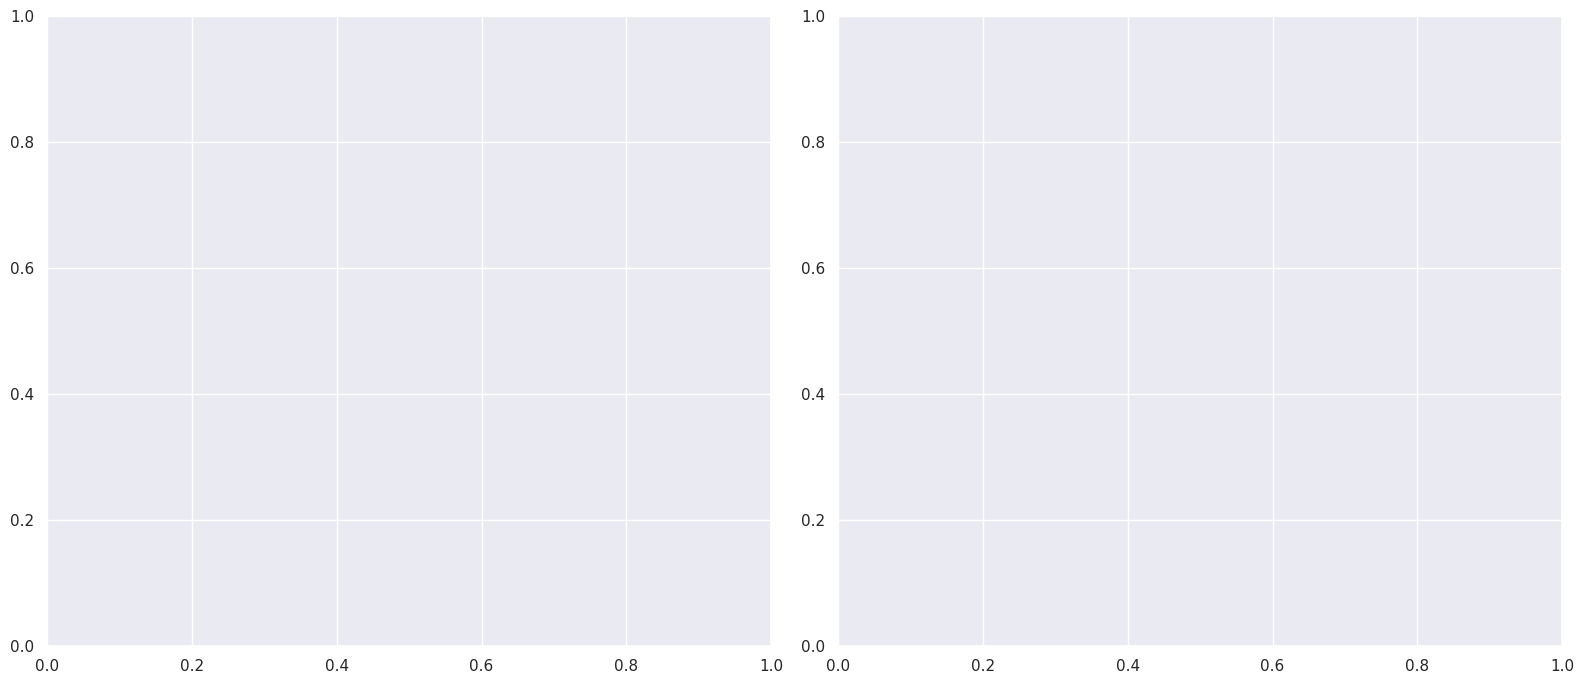


FIN DE LA SIMULACION


In [51]:
all_grids = model.datacollector.get_model_vars_dataframe()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

cmap = ListedColormap(['white', 'yellow', 'gray', 'red', 'purple', 'blue', 'orange', 'black'])
legend_elements = [
    Patch(facecolor='white', label='Vacio'),
    Patch(facecolor='yellow', label='Falsa Alarma'),
    Patch(facecolor='gray', label='Humo'),
    Patch(facecolor='red', label='Fuego'),
    Patch(facecolor='purple', label='Victima'),
    Patch(facecolor='blue', label='Bombero'),
    Patch(facecolor='black', label='Exterior')
]

def animate(i):
    ax1.clear()
    ax2.clear()

    grid = all_grids.iloc[i]['Grid']
    ax1.imshow(grid.T, cmap=cmap, vmin=0, vmax=7, origin='lower')
    ax1.set_title(f'Turno: {i}')
    ax1.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
    ax1.grid(True, alpha=0.3)


anim = animation.FuncAnimation(fig, animate, frames=len(all_grids), interval=200, repeat=False)
plt.tight_layout()
plt.show()

print(f"\n{'='*70}")
print("FIN DE LA SIMULACION")
print(f"{'='*70}")

In [52]:
anim

In [53]:
from collections import Counter

print("="*70)
print("FLASHPOINT: FIRE RESCUE - BATCH 100 SIMULACIONES")
print("="*70)

MAX_TURNS = 500
NUM_SIMS = 100

victorias = 0
derrotas = 0
victimas_salvadas_list = []

for sim in range(NUM_SIMS):
    model = FlashPointModel(width=10, height=10, num_firefighters=6)
    turn_count = 0

    while not model.game_over and turn_count < MAX_TURNS:
        model.step()
        turn_count += 1

    if model.victory:
        victorias += 1
    else:
        derrotas += 1

    victimas_salvadas_list.append(model.victims_saved)

    if (sim + 1) % 10 == 0:
        print(f"Progreso: {sim + 1}/100 simulaciones completadas")

victimas_counter = Counter(victimas_salvadas_list)
mas_repetido = victimas_counter.most_common(1)[0]

print(f"\n{'='*70}")
print("RESULTADOS FINALES")
print(f"{'='*70}")
print(f"Victorias: {victorias}")
print(f"Derrotas: {derrotas}")
print(f"Tasa de victoria: {victorias/NUM_SIMS*100:.1f}%")
print(f"\nVíctimas salvadas más repetido: {mas_repetido[0]} (ocurrió {mas_repetido[1]} veces)")
print(f"Promedio víctimas salvadas: {sum(victimas_salvadas_list)/NUM_SIMS:.2f}")
print(f"Mínimo: {min(victimas_salvadas_list)} | Máximo: {max(victimas_salvadas_list)}")

FLASHPOINT: FIRE RESCUE - BATCH 100 SIMULACIONES
Progreso: 10/100 simulaciones completadas
Progreso: 20/100 simulaciones completadas
Progreso: 30/100 simulaciones completadas
Progreso: 40/100 simulaciones completadas
Progreso: 50/100 simulaciones completadas
Progreso: 60/100 simulaciones completadas
Progreso: 70/100 simulaciones completadas
Progreso: 80/100 simulaciones completadas
Progreso: 90/100 simulaciones completadas
Progreso: 100/100 simulaciones completadas

RESULTADOS FINALES
Victorias: 6
Derrotas: 94
Tasa de victoria: 6.0%

Víctimas salvadas más repetido: 3 (ocurrió 22 veces)
Promedio víctimas salvadas: 3.04
Mínimo: 0 | Máximo: 7
